# Iris Classification with Softmax Regression
Using Hugging Face `scikit-learn/iris` with a single-layer softmax (multinomial logistic regression) in PyTorch, plus L2 weight decay.


In [1]:
# !pip install -q datasets  # Uncomment if the datasets library is missing

import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from datasets import load_dataset
import matplotlib.pyplot as plt
import numpy as np

torch.manual_seed(42)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")


Using device: cpu


In [2]:
# Load the Iris dataset
raw_dataset = load_dataset("scikit-learn/iris")
full_train = raw_dataset["train"]

print(full_train)
print("Columns:", full_train.column_names)

label_candidates = ["label", "target", "species", "Species"]
label_col = None
for cand in label_candidates:
    if cand in full_train.column_names:
        label_col = cand
        break
if label_col is None:
    raise ValueError(f"Could not find label column; available: {full_train.column_names}")

if "features" in full_train.column_names:
    feature_kind = "vector"
    def get_features(ds):
        return np.array(ds["features"], dtype=np.float32)
    feature_desc = "features vector"
else:
    feature_kind = "columns"
    feature_cols = [c for c in full_train.column_names if c not in {label_col, "Id", "id"}]
    def get_features(ds):
        return np.stack([ds[c] for c in feature_cols], axis=1).astype(np.float32)
    feature_desc = feature_cols

raw_labels = full_train[label_col]
if isinstance(raw_labels[0], str):
    label_names = sorted(set(raw_labels))
    label_to_id = {name: idx for idx, name in enumerate(label_names)}
    def encode_labels(seq):
        return [label_to_id[x] for x in seq]
else:
    label_names = None
    def encode_labels(seq):
        return seq

try:
    split = full_train.train_test_split(test_size=0.2, seed=42, stratify_by_column=label_col)
except Exception:
    split = full_train.train_test_split(test_size=0.2, seed=42)
train_split, val_split = split["train"], split["test"]

train_features = torch.tensor(get_features(train_split), dtype=torch.float32)
val_features = torch.tensor(get_features(val_split), dtype=torch.float32)
train_labels = torch.tensor(encode_labels(train_split[label_col]), dtype=torch.long)
val_labels = torch.tensor(encode_labels(val_split[label_col]), dtype=torch.long)

# Standardize features using training statistics
feat_mean = train_features.mean(dim=0, keepdim=True)
feat_std = train_features.std(dim=0, keepdim=True).clamp(min=1e-6)
train_features = (train_features - feat_mean) / feat_std
val_features = (val_features - feat_mean) / feat_std

train_ds = TensorDataset(train_features, train_labels)
val_ds = TensorDataset(val_features, val_labels)

batch_size = 32
num_workers = 2
train_loader = DataLoader(
    train_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers,
    pin_memory=torch.cuda.is_available(),
)
val_loader = DataLoader(
    val_ds, batch_size=batch_size, shuffle=False, num_workers=num_workers,
    pin_memory=torch.cuda.is_available(),
)

input_dim = train_features.shape[1]
num_classes = int(train_labels.max().item() + 1)
print(f"Feature mode: {feature_kind}, desc: {feature_desc}")
print(f"Labels: {label_names if label_names else 'numeric'}")
print(f"Features: {input_dim}, Classes: {num_classes}, Train: {len(train_ds)}, Val: {len(val_ds)}")


Dataset({
    features: ['Id', 'SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm', 'Species'],
    num_rows: 150
})
Columns: ['Id', 'SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm', 'Species']
Feature mode: columns, desc: ['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']
Labels: ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']
Features: 4, Classes: 3, Train: 120, Val: 30


In [3]:
# Softmax (multinomial logistic) regression
class SoftmaxRegression(nn.Module):
    def __init__(self, input_dim: int, num_classes: int):
        super().__init__()
        self.model = nn.Linear(input_dim, num_classes)

    def forward(self, x):
        return self.model(x)

model = SoftmaxRegression(input_dim, num_classes).to(DEVICE)
print(model)


SoftmaxRegression(
  (model): Linear(in_features=4, out_features=3, bias=True)
)


In [4]:
def accuracy(logits, labels):
    preds = logits.argmax(dim=1)
    return (preds == labels).float().mean().item()

def train_one_epoch(model, loader, criterion, optimizer):
    model.train()
    total_loss = 0.0
    total_acc = 0.0
    total = 0
    for features, labels in loader:
        features, labels = features.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        logits = model(features)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        batch = labels.size(0)
        total_loss += loss.item() * batch
        total_acc += accuracy(logits, labels) * batch
        total += batch

    return total_loss / total, total_acc / total

def evaluate(model, loader, criterion):
    model.eval()
    total_loss = 0.0
    total_acc = 0.0
    total = 0
    with torch.no_grad():
        for features, labels in loader:
            features, labels = features.to(DEVICE), labels.to(DEVICE)
            logits = model(features)
            loss = criterion(logits, labels)

            batch = labels.size(0)
            total_loss += loss.item() * batch
            total_acc += accuracy(logits, labels) * batch
            total += batch

    return total_loss / total, total_acc / total


In [5]:
epochs = 20
learning_rate = 1e-2
weight_decay = 5e-3  # L2 regularization strength

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

for epoch in range(epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer)
    val_loss, val_acc = evaluate(model, val_loader, criterion)

    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    if (epoch + 1) % 20 == 0 or epoch == 0:
        print(
            f"Epoch {epoch + 1}/{epochs} - train loss: {train_loss:.4f}, train acc: {train_acc:.3f}, val loss: {val_loss:.4f}, val acc: {val_acc:.3f}"
        )


Epoch 1/20 - train loss: 1.0775, train acc: 0.342, val loss: 0.9204, val acc: 0.500
Epoch 20/20 - train loss: 0.4135, train acc: 0.850, val loss: 0.3607, val acc: 0.900


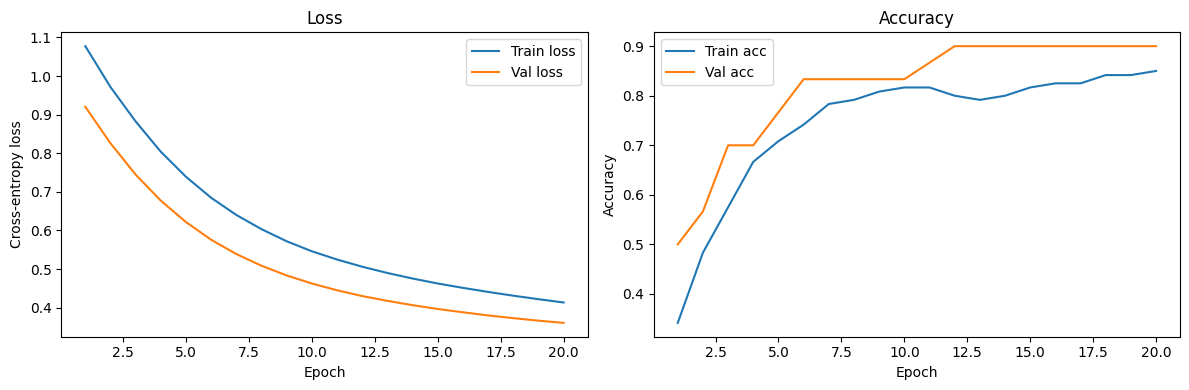

In [6]:
epochs_range = range(1, epochs + 1)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(epochs_range, history["train_loss"], label="Train loss")
axes[0].plot(epochs_range, history["val_loss"], label="Val loss")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Cross-entropy loss")
axes[0].legend()
axes[0].set_title("Loss")

axes[1].plot(epochs_range, history["train_acc"], label="Train acc")
axes[1].plot(epochs_range, history["val_acc"], label="Val acc")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
axes[1].legend()
axes[1].set_title("Accuracy")

plt.tight_layout()
plt.show()
